# **Amazon Baby Products Review - Group 14**

# 1. The project

In this competition we predict customer sentiments regarding [Baby products purchased on Amazon.com](http://jmcauley.ucsd.edu/data/amazon/), on the basis of their written reviews.

**1. Data origin and qualities**

* The data for this project are obtained from Amazon customer reviews of baby products, gathered by Amazon itself through their website by inviting customers to enter a review of a baby product that they had bought. This includes reviews and ratings on a 1 to 5 scale. The data was obtain from http://jmcauley.ucsd.edu/data/amazon/ thanks to Professors Emily Fox, Ph.D. and Carlos Guestrin, Ph.D.

* The results of this analysis will mostly apply to a specific subset of Amazon customers who are interested in purchasing baby products. Generalizing these findings to all Amazon customers may not be valid, as those who leave online reviews (especially for baby products) might have different characteristics. For example, they might have been encouraged by Amazon to provide feedback. It's essential to think about these specifications before drawing conclusions or making decisions.

**2. Potential machine learning methods and features**

* Candidate machine learning methods for this project include linear and logistic regression. The goal is to predict customer ratings based on their review text (rating 4,5 OR rating 1, 2, 3).

* Given that the outcome variable can be categorized as either satisfied or not satisfied (binary), logistic regression is a suitable choice. Additionally, ridge and lasso regression, along with forward feature selection, are potential methods to explore.

* Feature engineering can leverage various text analysis sentiment features, such as sentiment scores, as well as general text attributes like stopwords and text length. Special emphasis will be placed on using TF-IDF (Term Frequency-Inverse Document Frequency).

**3. Bayes' error bound?**

* It's also important to consider the Bayes' error bound when developing our predictive models. The Bayes' error rate provides a statistical lower limit on the achievable error rate for a given classification problem and the choice of features. Estimating this rate helps assess the effectiveness of the feature set used for classification.

* In our case, the outcome variable consists of 5-star ratings, with varying frequencies for each rating category (1 - 12735, 2 - 9448, 3 - 14010, 4 - 27695, 5 - 89643). By calculating the probability of a review being classified as satisfied* (rating > 3), we find that it's approximately 0.764 (117,338 / 153,531 ≈ 0.764), so 76.4%. This indicates a very low Bayes' error bound, suggesting that even a simple model should perform reasonably well.

*Total number of ratings > 3 (satisfied): 27,695 (4-star) + 89,643 (5-star) = 117,338 Total number of ratings 1 through 5: 12,735 (1-star) + 9,448 (2-star) + 14,010 (3-star) + 27,695 (4-star) + 89,643 (5-star) = 153,531

# 2. Reading Data

## 2.1. Libraries

In [1]:
# Importing libraries
library(tidyverse)
library(tidytext)
library(wordcloud)
library(caret)
library(pls)
library(pROC)
library(splines)

## Data attached to this notebook
list.files(path = "../input")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: RColorBrewer

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘pls’


The following object is masked from ‘package:caret’:

    R2


The following object is masked from ‘package:stats’:

    loadings


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The foll

[1] "customer-sentiment-from-reviews-bda-2023"

## 2.2. Creating more memory

In high level programming languages, a garbage collector is a background program that will automatically clear out unused objects from memory every so often. This alleviates the programmer from having to code this step manually, as is required in low level languages, and prevents common problems like memory overflow, caused by forgetting to delete unused objects from memory. However, instead of waiting for the garbage collector to do its next round, you can call it manually too in R via the gc() function. Usage of the gc() function is demonstrated here, and may be used throughout this notebook to optimize performance. For most projects it's not necessary to use gc() manually, but for this notebook it might lead to improved performance, seeing as the data sets that are processed here have an uncompressed size of up to and over 40 gigabytes, and most mid- to upper range machines typically only have 8 to 16 gigabytes of RAM available, which is also used for other programs like your browser and the OS itself.

In [2]:
# Example usage of a manual call to the garbage collector
gc(verbose=TRUE, full=TRUE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2642692,141.2,4690848,250.6,4690848,250.6
Vcells,4443809,34.0,10146329,77.5,6778731,51.8


## 2.3. Locating and loading the data into memory

In [3]:
dir("../input", recursive=TRUE)

[1] "customer-sentiment-from-reviews-bda-2023/amazon_baby_testset_sample.csv"
[2] "customer-sentiment-from-reviews-bda-2023/amazon_baby.csv"

In [4]:
# Find the right file path
csv_filepath = dir("..", pattern="amazon_baby.csv", recursive=TRUE, full.names = TRUE)

# Read in the csv file
amazon = read_csv(csv_filepath, show_col_types = FALSE) %>%
    rownames_to_column('id') 

head(amazon)

id,name,review,rating
<chr>,<chr>,<chr>,<dbl>
1,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion not worth keeping. I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality. I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.",3
2,Planetwise Wipe Pouch,it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.,5
3,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,NA
4,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"This is a product well worth the purchase. I have not found anything else like this, and it is a positive, ingenious approach to losing the binky. What I love most about this product is how much ownership my daughter has in getting rid of the binky. She is so proud of herself, and loves her little fairy. I love the artwork, the chart in the back, and the clever approach of this tool.",5
5,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love\'s Binky Fairy Puppet. It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!! You will save them soo many headaches.Thanks for this book! You all rock!!",NA
6,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"When the Binky Fairy came to our house, we didn\'t have any special gift and book to help explain to her about how important it is to stop using a pacifier. This book does a great job to help prepare your child for the loss of their favorite item. The doll is adorable and we made lots of cute movies with the Binky Fairy telling our daughter about what happens when the Binky Fairy comes. I would highly recommend this product for any parent trying to break the pacifier or thumb sucking habit.",5


The data frame contains both the train and test data. The test data are the reviews for which the rating is missing and you need to provide a prediction. 

The following logical index variable will be of help selecting the desired rows without the need to split the data frame into seperate sets. This makes it easier to extract features.

In [5]:
# Needed for base Bayes' lower error bound
amazon %>%
    count(rating)

rating,n
<dbl>,<int>
1,12735
2,9448
3,14010
4,27695
5,89643
NA,30000


From the above, there are 153,531 training samples and 30,000 test samples.

# 3. Preprocessing

The table contains, the product `name`, the textual `review`, and the `rating`.

## 3.1 Tokenization

Tidytext is used to break up the text into separate tokens and count their the number of occurences per review. A token can be a word, special character (like '!', or '-'), or multiple words (i.e. n-grams).

First, the name of the product is prepended to each review, since some products will always be received more positively or negatively than others, which is valuable information for the purposes of making predictions about the sentiment of reviews. Another problem solved by this procedure, is that it will allow predictions to be made for empty reviews. By prepending the product name to the review, at least the name will be available from which to predict the ratings.

In [6]:
# Paste name and review into a single string separated by a "–".
# The new string replaces the original review.
amazon = amazon %>%

    unite(review, name, review, sep = " — ", remove = FALSE) %>%

   # Recode ratings into > 3 satisfied and </= 3 dissatisfied
   mutate(rating = ifelse(rating > 3, "satisfied", "dissatisfied"))

print(amazon)

# A tibble: 183,531 × 4
   id    review                                                     name  rating
   <chr> <chr>                                                      <chr> <chr> 
 1 1     "Planetwise Flannel Wipes — These flannel wipes are OK, b… "Pla… dissa…
 2 2     "Planetwise Wipe Pouch — it came early and was not disapp… "Pla… satis…
 3 3     "Annas Dream Full Quilt with 2 Shams — Very soft and comf… "Ann… NA    
 4 4     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto… satis…
 5 5     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto… NA    
 6 6     "Stop Pacifier Sucking without tears with Thumbuddy To Lo… "Sto… satis…
 7 7     "A Tale of Baby\\'s Days with Peter Rabbit — Lovely book,… "A T… satis…
 8 8     "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab… NA    
 9 9     "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab… satis…
10 10    "Baby Tracker&reg; - Daily Childcare Journal, Schedule Lo… "Bab… satis…
# ℹ 

Here, each review will have its unique tokens (words and special characters) counted. Each row will hold one token's count for a given review. To keep track of the review to which the row belongs, the rownames are added as `id`, which is simply the row number. So, each review will have multiple rows.

#### Stopwords

We decided to exclude stopwords from the snowball lexicon. These are words that occur frequently but do not usually carry much meaning. Although some of these words may relate to the sentiment of a review, the number of predictors will already be very large. Stopwords seem like a reasonable group of tokens to exclude.

In [7]:
stopwords <- get_stopwords() %>% mutate(token = word, .keep = "unused")

reviews_uni = amazon %>%
    
   # Tokinize reviews at word level
    unnest_tokens(token, review, token = "words", strip_punct = FALSE) %>%

    anti_join(stopwords, by = "token") %>% # remove stopwords

   # Count tokens within reviews as 'n'
   # Keep id, name, and rating in the result
    count(id, name, rating, token)

head(reviews_uni)

dim(reviews_uni)

id,name,rating,token,n
<chr>,<chr>,<chr>,<chr>,<int>
1,Planetwise Flannel Wipes,dissatisfied,",",4
1,Planetwise Flannel Wipes,dissatisfied,-,2
1,Planetwise Flannel Wipes,dissatisfied,.,3
1,Planetwise Flannel Wipes,dissatisfied,12,1
1,Planetwise Flannel Wipes,dissatisfied,6,1
1,Planetwise Flannel Wipes,dissatisfied,8,1


[1] 8711891       5

In addition to single-word tokens, we tokenized each review into bigrams. Bigrams are adjacent words (this case) found in the dataset. Unigrams indicate each word separately, bigrams investigate pair of words occuring next to each other and trigrams investigate a group of three words cooccuring next to each other.
However, having features for both unigrams and bigrams proved too computationally demaing during model fitting (exceeding available RAM), so we decided to exclude bigrams from our features. 

In [8]:
# Tokenizing based on bigrams
# reviews_bi = amazon %>%
    
   # tokinize reviews at bigram level
   # unnest_tokens(token, review, token = "ngrams", n = 2) %>%

   # count tokens within reviews as 'n'
   # (keep id, name, and rating in the result)
   # count(id, name, rating, token)

# head(reviews_bi)

# dim(reviews_bi)

In [9]:
reviews = reviews_uni

## 3.2 Data Exploration
Creating a wordcloud for dissatisfied and satisfied customer reviews (inspired from Group 1). The word clouds will show the 100 most frequently observed tokens among their respective review types. The word clouds can quickly show the words that are likely to be key in predicting sentiment.

Some things that pop out from the negative word cloud are words like: didn't, doesn't, don't, dissapointed, bad, and hard. It's easy to imagine why these words might be prevalent among negative reviews, and less so to non-existant in positive ones.

Likewise, words that pop out for positive reviews are: comfortable, happy, loved, super, recommended, highly, easily, sturdy, love, and clean. It's not hard to imagine why these frequently occur in positive reviews either, and will likely never be found in negative ones.

Unsurprisingly, the em-dash character used to paste product names and reviews together is very common among both sentiment types.

The word clouds indicate that positive and negative reviews could be quite well discernable from one another.

Joining with `by = join_by(token)`
Joining with `by = join_by(token)`


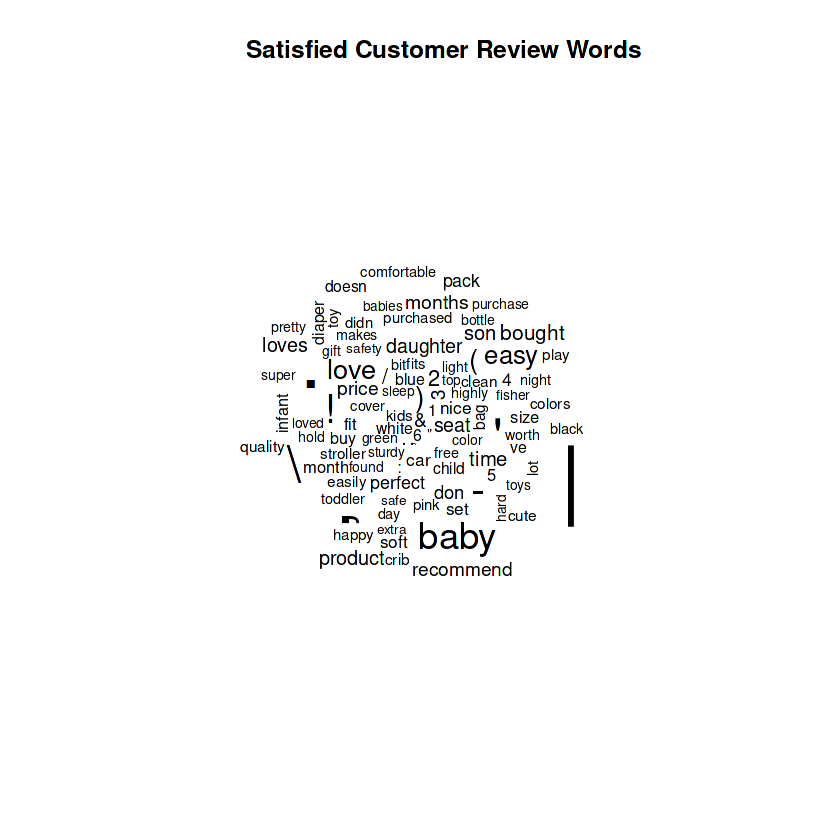

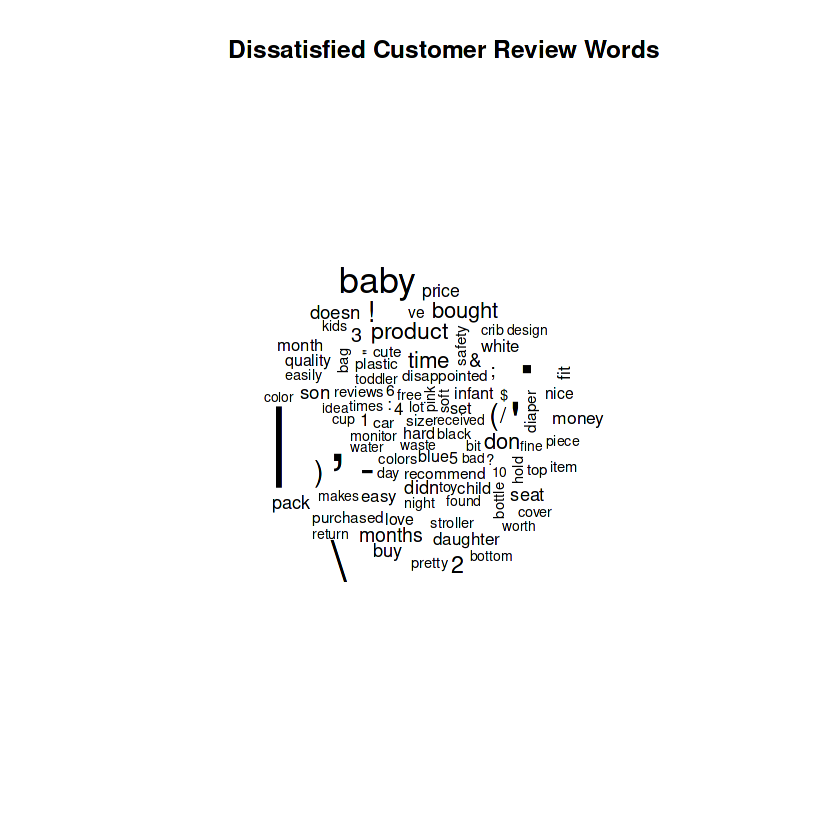

In [10]:
# Getting stop words to remove from the wordclouds
data(stop_words)
colnames(stop_words)[1] = "token"

# Wordcloud for satisfied reviews
satisfied_reviews = reviews_uni %>%
  filter(rating == "satisfied") %>%
  anti_join(stop_words) %>%
  count(token)

wordcloud(satisfied_reviews$token, satisfied_reviews$n, max.words = 100)
title("Satisfied Customer Review Words")

# Wordcloud for dissatisfied reviews
dissatisfied_reviews = reviews_uni %>%
  filter(rating == "dissatisfied") %>%
  anti_join(stop_words) %>%
  count(token)

wordcloud(dissatisfied_reviews$token, dissatisfied_reviews$n, max.words = 100)
title("Dissatisfied Customer Review Words")

# 4. Features engineering

Features computed for tokens in text are based on the Bag of Words (BoW) model: Each document is considered a bag of words, in wich order plays no particular role.

## Used features:

- **Term frequency (TF, IDF, TFIDF)**: 
    > Express the frequency of tokens within and between documents
    
- **Token counts**:
    > Counts the number of tokens
    
- **Number of words in review**:
    > Summarizing number of words in each input per individual
    
- **Word to punctuation ratio**:
    > Calculates punctuation to word ratio for each unique review id
    
- **Frequency of satisfied reviews**:
    > Adds satisfaction ratio (frequency) to each review id
 

## 4.1 Token-Based Features

### Feature #1: Token counts

Our first feature is simply the number of times each token occurs in a review. For example, a review that mentions a negative word several times is likely to be dissatisfied. This features was already calculated during the tokenization of the reviews, so we merely turn it into a format that will allow for mergin with our other features later.

In [11]:
n_occ = reviews %>%
    # Maintain only identifiers (id, name), category (rating), feature name (token), and value (n)
    select(id, name, rating, token, n) %>%
    # Change column and token names
    mutate(feature = paste(token, "n_occ", sep="_"), value = n, .keep = "unused") %>%
    # Re-order for merging
    select(id, feature, value) 

head(n_occ)
dim(n_occ)

id,feature,value
<chr>,<chr>,<int>
1,",_n_occ",4
1,-_n_occ,2
1,._n_occ,3
1,12_n_occ,1
1,6_n_occ,1
1,8_n_occ,1


[1] 8711891       3

### Feature #2: TF, IDF, TF-IDF for unigrams

Here, we compute three features that express a token's frequency within a review and relative to other reviews. We adopted the explanations of these features from the Quickstart notebook.

- **Term frequency ($TF_{d,t}$)**: 
    > The relative frequency of a term within a document $\displaystyle {n_{d,t} \over  \sum_t n_{d,t}}$
    
    > The more often a token $t$ occurs in a document, the more likely it is that the topic of the document is closely related to that token
    
    > It does not take into account that certain words simply occur more frequently because of their role in language (such as 'a', 'but', etc.)

- **Inverse document frequency ($IDF_t$)**: 
    > inverse the relative frequency with which a term occurs among the $N$ documents, expressed on a log scale (a measure of 'surprise') as  $-\log\left({DF_t \over N}\right)$ Here $DF_t$ is the number of documents that contain the token $t$.
    
    > The more wide spread the use of a token $t$ is among all documents, the less likely it conveys information about the topic of any particular document
    
    > The more surprising a word is, the more likely it conveys information about the topic of the document in which it is found

- **the $TFIDF_{d,t}$**: 
    > the product of TF and IDF --> quantifies the important of a term for a given document
    
    > $IDF_t$ part has much less use over $TF_{d,t}$ in *predictive* models because the $IDF_t$ part simply scales the $TF_{d,t}$ features accross documents (effect on scale sensitive algorithms e.g.: PCA, kNN)
    
    > $TFIDF_{d,t}$ is very successful in document retrieval systems (i.e., search engines)

#### Non-zero variance tokens
Tokens that only occur in very few reviews (i.e., the binary/count equivalent of variance) will not help us to predict the sentiment of additional reviews. Therefore, we filtered out tokens that occur in less gthan 0.01% (~18) reviews. Based on the calculation of the IDF $$IDF_t = -\log\left({\text{df}_t \over N}\right) = -\log(\text{proportion of document in which }t\text{ occurs})$$ these are tokens with an IDF (i.e., surprise factor) of −log(0.01/100)) or higher.

In [12]:
reviews_tf_idf = reviews %>%

    # TF-IDF for each word per sentence
    bind_tf_idf(token, id, n) %>%

    # Words that are not present should be 0 (not NA)
    replace_na(list(tf=0, idf=Inf, tf_idf=0)) %>%

    # filter tokens that occur in less than 0.01% of reviews
    filter(idf <= -log(0.01/100))

# TF
reviews_tf = reviews_tf_idf %>%
    # maintain only identifiers (id, name), category (rating), feature name (token), and value (tf)
    select(id, name, rating, token, tf) %>%
    mutate(feature = paste(token, "tf", sep="_"), value = tf, .keep = "unused") %>%
    select(id, feature, value) # re-order for merging

# IDF
reviews_idf = reviews_tf_idf %>%
    # maintain only identifiers (id, name), category (rating), feature name (token), and value (idf)
    select(id, name, rating, token, idf) %>%
    mutate(feature = paste(token, "idf", sep="_"), value = idf, .keep = "unused") %>%
    select(id, feature, value) # re-order for merging

# TF-IDF
reviews_tf_idf = reviews_tf_idf %>%
    # maintain only identifiers (id, name), category (rating), feature name (token), and value (tf_idf)
    select(id, name, rating, token, tf_idf) %>%
    mutate(feature = paste(token, "tf_idf", sep="_"), value = tf_idf, .keep = "unused") %>%
    select(id, feature, value) # re-order for merging

reviews_tf_idf = rbind(reviews_tf, reviews_idf, reviews_tf_idf)

In [13]:
head(reviews_tf_idf)
tail(reviews_tf_idf)
dim(reviews_tf_idf)

id,feature,value
<chr>,<chr>,<dbl>
1,",_tf",0.06557377
1,-_tf,0.03278689
1,._tf,0.04918033
1,12_tf,0.01639344
1,6_tf,0.01639344
1,8_tf,0.01639344


id,feature,value
<chr>,<chr>,<dbl>
99999,research_tf_idf,0.09566643
99999,seat_tf_idf,0.08516150
99999,seats_tf_idf,0.07738138
99999,summer_tf_idf,0.06828532
99999,t_tf_idf,0.02098893
99999,—_tf_idf,0.00000000


[1] 25472451        3

#### Correlated and linear combinations of features 

Although correlated (linear combinations of) features may exist, with thousands of features it's computationally too cumbersome to try to remove them directly. Instead we'll have to rely on the properties of the Lasso and Ridge regression to deal with them.

* The caret function of high correlations and linear combinations have been used at review based features

### Feature #3: AFINN lexicon

This was taken from Competition #1



Before we can start using the lexicons, we have to get the lexicon data.

In [14]:
# Helper function to retrieve different lexicons from the 'textdata' package
get_lexicon = function(lexicon_name = names(textdata:::download_functions)) {
    lexicon_name = match.arg(lexicon_name)
    textdata:::download_functions[[lexicon_name]]('.')
    rds_filename = paste0(lexicon_name,'.rds')
    textdata:::process_functions[[lexicon_name]]('.',rds_filename)
    readr::read_rds(rds_filename)
}

This has been obtained from Competition #1

The AFINN lexicon assigns a numerical score between -5 to 5 to each word on its list. Here we create a feature that calculates the afinn sentiment for each review.


In [15]:
afinn = get_lexicon('afinn')
colnames(afinn)[1] = "token"

afinn_scores = reviews %>%
  # Overall afinn score
  inner_join(afinn, by = "token", relationship = "many-to-many") %>%
  group_by(id) %>%
  summarise(value = sum(value)) %>%

  # Formatting dataframe
  mutate(feature = "afinn score", .before = value)

head(afinn_scores)
tail(afinn_scores)
dim(afinn_scores)

id,feature,value
<chr>,<chr>,<dbl>
1,afinn score,2
10,afinn score,3
100,afinn score,6
1000,afinn score,3
10000,afinn score,5
100000,afinn score,3


id,feature,value
<chr>,<chr>,<dbl>
99994,afinn score,3
99995,afinn score,9
99996,afinn score,26
99997,afinn score,1
99998,afinn score,2
99999,afinn score,9


[1] 179010      3

## 4.2 Review-Based Features

### Feature #4: Number of words in review

The length of dissatisfied reviews may differ from that of satisfied reviews, presumably because dissatisfied reviewers elaborate more on their complaints. That is why this feature counts the number of words in each review.

In [16]:
n_of_words = reviews %>%
    group_by(id) %>%

    # Summarizing n's in each input per id (individual)
    mutate(value = sum(n)) %>%

    # maintain only one row per review
    select(id, value, name, rating) %>%
    distinct() %>%

    # add feature label
    mutate(feature = "rev_length") %>%

    # re-order for merging
    select(id, feature, value) 

head(n_of_words)
tail(n_of_words)
dim(n_of_words)

id,feature,value
<chr>,<chr>,<int>
1,rev_length,61
10,rev_length,57
100,rev_length,28
1000,rev_length,157
10000,rev_length,34
100000,rev_length,19


id,feature,value
<chr>,<chr>,<int>
99994,rev_length,30
99995,rev_length,47
99996,rev_length,99
99997,rev_length,68
99998,rev_length,26
99999,rev_length,49


[1] 183531      3

### Feature #5: Word to punctuation ratio

Here, we compute a feature that counts the amount of punctuation in each review relative to the number of words. The rationale is that negative reviews tend to be more emotionally charged, which is often expressed in more punctuation than is grammatically necessary (think elipses ..., question marks ???, or exclamation marks !!!). This feature is different from simply using amount of punctuation as a predictor because it takes into account how much punctuation would usually be used in a review of a certain length.

In [17]:
# Calculate punctuation to word ratio for each unique review id
punct_word_ratio = reviews %>%
    group_by(id) %>%
    mutate(value = sum(grepl("[[:punct:]]+", token)) / n()) %>%

    # maintain only one row per review
    select(id, value, name, rating) %>%
    distinct() %>%

    # add feature label
    mutate(feature = "punct_word_ratio") %>%

    # re-order for merging
    select(id, feature, value) 

head(punct_word_ratio)
tail(punct_word_ratio)
dim(punct_word_ratio)

id,feature,value
<chr>,<chr>,<dbl>
1,punct_word_ratio,0.08163265
10,punct_word_ratio,0.20833333
100,punct_word_ratio,0.21739130
1000,punct_word_ratio,0.14285714
10000,punct_word_ratio,0.19354839
100000,punct_word_ratio,0.17647059


id,feature,value
<chr>,<chr>,<dbl>
99994,punct_word_ratio,0.16666667
99995,punct_word_ratio,0.07692308
99996,punct_word_ratio,0.11392405
99997,punct_word_ratio,0.13461538
99998,punct_word_ratio,0.13636364
99999,punct_word_ratio,0.15909091


[1] 183531      3

#### Non-zero variance tokens
The number of review-wide features is more manageable, so we can use the caret package to detect and remove predictors with near-zero variance, high correlations, and linear redundancies. In the same step, we also combine all review-based features into one long data frame that is ready for merging with the other features.

In [18]:
# Check review-based features for near-zero variance, multicolliniearity, and redundant linear combintations

# Join review-based features and bring into wide format
rev_based = rbind(n_of_words, punct_word_ratio) %>% pivot_wider(names_from=feature, values_from=value)

# Look for near-zero variance predictors
near_zero_var = caret::nearZeroVar(rev_based[,2:3])

# Look for correlated predictors
high_cor = caret::findCorrelation(cor(rev_based[,2:3]))

# Look for linear combinations that predict other predictors
linear_combo = caret::findLinearCombos(rev_based[,2:3])

# Remove recommended predictors
clean_rev_based = rev_based %>%
    select(,-c(high_cor, linear_combo$remove)) %>%

    # Turn back into long format for merging with other features
    pivot_longer(c(rev_length, punct_word_ratio), names_to = "feature", values_to = "value")

# Take a look
head(clean_rev_based)
tail(clean_rev_based)
dim(clean_rev_based)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(high_cor)

  # Now:
  data %>% select(all_of(high_cor))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


id,feature,value
<chr>,<chr>,<dbl>
1,rev_length,61.00000000
1,punct_word_ratio,0.08163265
10,rev_length,57.00000000
10,punct_word_ratio,0.20833333
100,rev_length,28.00000000
100,punct_word_ratio,0.21739130


id,feature,value
<chr>,<chr>,<dbl>
99997,rev_length,68.0000000
99997,punct_word_ratio,0.1346154
99998,rev_length,26.0000000
99998,punct_word_ratio,0.1363636
99999,rev_length,49.0000000
99999,punct_word_ratio,0.1590909


[1] 367062      3

## 4.3 Global Features

### Feature #6 Frequency of satisfied reviews

Independent of all other features, any new review is more likely to be satisfied than dissatisfied simply because satisfied reviews are much more common in general. Therefore, we decided to compute a feature that expresses the relative frequency of satisfied reviews.

In [19]:
# Number of satisfied reviews
n_satisfied = reviews %>%
  filter(rating == "satisfied") %>%
  nrow()

# Add satisfaction ratio to each review id
satis_ratio = reviews %>%
  group_by(id) %>%
  mutate(value = n_satisfied / nrow(reviews)) %>%

  # Maintain only one row per review
  select(id, value, name, rating) %>%
  distinct() %>%
  
  # Add feature label
  mutate(feature = "satis_ratio") %>%
  
  # Re-order for merging
  select(id, feature, value)

head(satis_ratio)
tail(satis_ratio)
dim(satis_ratio)

id,feature,value
<chr>,<chr>,<dbl>
1,satis_ratio,0.6232475
10,satis_ratio,0.6232475
100,satis_ratio,0.6232475
1000,satis_ratio,0.6232475
10000,satis_ratio,0.6232475
100000,satis_ratio,0.6232475


id,feature,value
<chr>,<chr>,<dbl>
99994,satis_ratio,0.6232475
99995,satis_ratio,0.6232475
99996,satis_ratio,0.6232475
99997,satis_ratio,0.6232475
99998,satis_ratio,0.6232475
99999,satis_ratio,0.6232475


[1] 183531      3

## 4.3 Features into Sparse Matrix

In this step, we bring it all together, mergin all features into one long data frame with review IDs in one column, the feature name in another, and the corresponding value in another.

In [20]:
all_pred = rbind(n_occ, reviews_tf_idf, clean_rev_based, satis_ratio, afinn_scores)

head(all_pred)
tail(all_pred)
dim(all_pred)

id,feature,value
<chr>,<chr>,<dbl>
1,",_n_occ",4
1,-_n_occ,2
1,._n_occ,3
1,12_n_occ,1
1,6_n_occ,1
1,8_n_occ,1


id,feature,value
<chr>,<chr>,<dbl>
99994,afinn score,3
99995,afinn score,9
99996,afinn score,26
99997,afinn score,1
99998,afinn score,2
99999,afinn score,9


[1] 34913945        3

Given the large number of features we have computed, fitting models on a regular data frame or dense matrix would take up too much RAM. Therefore, we cast our features into a sparse matrix. The new sparse matrix has a row for each review and a column for each feature. It saves RAM by disregarding cells with missing input.

In [21]:
# Turn features into a sparse design matrix 
features_sparse = all_pred %>% 
    cast_sparse(id, feature, value) 

# Check result
features_sparse[1:10,1:5]
cat("rows, columns: ", dim(features_sparse))

10 x 5 sparse Matrix of class "dgCMatrix"
       ,_n_occ -_n_occ ._n_occ 12_n_occ 6_n_occ
1            4       2       3        1       1
10           1       2       2        .       .
100          1       .       .        .       .
1000         9       2       8        .       .
10000        2       .       3        .       .
100000       1       .       1        .       .
100001       1       .       3        .       .
100002       3       .       3        .       .
100003       1       .       4        .       .
100004       1       .       3        .       .

rows, columns:  183531 146915


# 5. Models

Due the large number of feature, it would be difficult to select suitable features by hand. However, state-of-the-art methods can deal with large numbers of features and automatically surpress useless predictors. We looked at the following models:

1. **Principal Components Regression**
2. **Partial Least Squares Regression**
3. **Lasso Regression**
4. **Ridge Regression**
5. **Smoothing**

Methods (1), (2), (3), (4) on this list involve methods are able to take many features while automatically reducing redundant flexibility to any desired level. Multicollinearity (highly correlated linear combinations of features) is also automatically taken care of by these methods.

Number (5) on the list, smoothing, grants more flexibility by allowing for some non-linearity in the relations between features and the target variable, without the need to manually specify a specific mathematical form (as is necessary in polynomial regression).

Hence, all of these methods remove the necessity of finding the best features by hand. 

All of these methods are associated with a small set of 1 to 3 (or 4 in some cases) parameters that control the flexibility of the model in a more or less continuous way&mdash;much like the $k$ parameter in k-nearest neighbers. Like the $k$ parameter in k-NN, these parameters can and need to be adjusted (*'tuned'*) for optimal predictive performance. Tuning is best done on a validation set (a subset from the training data), or using cross-validation, depending on the size of the data set.

## 5.1 Model fitting

Not all algorithms can deal with sparse matrices. For instance `lm()` can't. The `glmnet` package, that is extensively discussed in chapter 6 of ISLR, can handle sparse matrices and use lasso and ridge regression. Also refer back to the [Spooky authors](https://www.kaggle.com/datasniffer/huge-design-matrices-spooky-author) lab exercise for an example in the context of text analytics.

The aim of this competition is the predict the probability that a customer is ***satisfied***. This is deemed to be the case if `rating > 3`.  Hence, you will need as a dependent variable `y` a factor that specifies whether this is the case. 

The performance of your submission will be evaluated using the ***area under the curve*** (**AUC**) of the *receiver operating curve* (*ROC*). (See chapter 4 in the ISLR book.) The function `cv.glmnet` can work with this measure — carefully read the help file of this function.

The type of regularization (i.e., the lasso or ridge) that is used by `glmnet` is controled by the `alpha` parameter. Refer to the book for an explanation. The amount of regularization is specified by means of the `lambda` parameter. Read the warning in the `help(glmnet)` documentation about changing this parameter. To tune this parameter look at the `cv.glmnet()` function.


In [22]:
# Call garbage collector to clear up memory
gc(verbose=TRUE, full=TRUE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4393348,234.7,13572439,724.9,41419791,2212.1
Vcells,356057104,2716.6,580693266,4430.4,580607856,4429.7


Before we can run fit our models, we need to separate the test data into features and outcome variable and separate the test from the training data. Our design matrix only contains one row per review and there is only one rating per review, so we ensure that our outcome vector and design matrix will have the same number of elements/rows by only maintaing one row per review. The new ratings data frame only contains the ID, name, and rating for each review.

Similarly, the order of reviews should also be the same in the design matrix and the vector with the ratings. We achieve this by inner-joining the ratings data frame with the IDs from the design matrix and subsequently extracting the ratings as a vector.

The test data consists of all observations without a rating, so we look for rows in our tokenized reviews for whom the rating is NA. We then remove the corresponding rows from our training design matrix and training ratings vector.

To be able to run our model-fitting functions in a reasonable time, we use only a sub-sample of observations for the following steps.

In [23]:
# Creating a data frame with one row and rating per review
train_ratings = reviews %>% select(id, name, rating) %>% distinct()

# Alligning the order of IDs in the design matrix and the ratings data frame
y = data.frame(id=rownames(features_sparse)) %>% 
    inner_join(train_ratings, by = "id") %>% 
    # Extract the ratings as a factor
    pull(rating) %>%
    as.factor()

# Removing test rows from training data
na_ind = which(is.na(train_ratings$rating))
train_sparse = features_sparse[-na_ind,]
y = y[-na_ind]

train_ind = sample(1:length(y), 20000) # Random subset of observations
train_sparse = train_sparse[train_ind,]
y = y[train_ind]

# Gauge results
train_sparse[200:210, 50:54]
head(y)

11 x 5 sparse Matrix of class "dgCMatrix"
       &_n_occ '_n_occ 5_n_occ ;_n_occ \\_n_occ
39354        .       4       1       .        4
49672        .       .       .       .        .
61664        .       3       .       .        3
114370       .       1       .       .        1
134455       .       1       1       .        1
34212        .       3       .       .        3
75676        .       2       .       .        2
71242        .       4       .       .        4
112552       .       .       .       .        .
143915       .       2       .       .        2
77374        .       3       .       .        3

[1] dissatisfied satisfied    satisfied    dissatisfied satisfied   
[6] satisfied   
Levels: dissatisfied satisfied

### 5.1.1. Principal Component Regression (PCR)

In principal component regression (PCR), regression is done on principal component scores obtained from a principal component analysis (PCA). PCA is an unsupervised dimenionality reduction technique, which transforms data into a new set of components, such that most variance is held by the first component, and the remainder is distributed among the others in descending order. Selecting a subset of these components reduces the number of variables, while retaining as much information as possible. Therefore, PCR is useful in this case because it provides a way to combat the excessive number of predictors. Here, logistic regression is used for the type of model.

In blocks 1 to 6, the data frame meant for the PCR is created, which involves obtaining the principal components of the data, among other minor preprocessing steps. The logistic regression is done in Block 7, and evaluated in Block 8.

In [24]:
## Block
# Create X and y2

# y2 is used instead of y, so any changes won't interfere with
# other model fitting code elsewhere. The same reasoning applies
# to creation of the X variable, which is essentially the same as
# the train_sparse variable.

max_len_y = 1000

if (length(y) > max_len_y) {
    # If the number of cases is greater than some number, then
    # limit the number of cases to train on. This precaution makes
    # sure that the code won't take too long.
    train_indx = sample(1:length(y), max_len_y)
    X = train_sparse[train_indx, ]#  %>% as("matrix") %>% as.data.frame()
    y2 = y[train_indx]    
    
    # Clear R workspace
    rm(train_indx)
    
    cat(sprintf("Limited number of training cases to %s\n", max_len_y))
    
} else {
    # Create X and y2
    X = train_sparse# %>% as("matrix") %>% as.data.frame()
    y2 = y
}

cat("Created X and y2")
dim(X)
length(y2)

Limited number of training cases to 1000
Created X and y2

[1]   1000 146915

[1] 1000

In [25]:
## Block 2

# Drop cases where y is NA. This step should be done earlier in the
# preprocessing, but it's done here in order not interfere with the 
# earlier code. Eventually the NA cases will be excluded at an earlier 
# stage, and this step won't find any NA cases to drop anyway.
na_mask = ! is.na(y2)
head(na_mask)
if (sum(! na_mask) > 0) {
  y2 = y2[na_mask]
  X = train_sparse[na_mask, ]
  cat("Debug 1\n")
}

cat(str_c("Dropped ", sum(! na_mask), " cases where y was NA"))

[1] TRUE TRUE TRUE TRUE TRUE TRUE

Dropped 0 cases where y was NA

In [26]:
## Block 3
# Drop near zero variance columns, since prcomp() will complain about this.
# Note. This step will take some time.
to_drop = nearZeroVar(X)
if (length(to_drop) > 0) {
  X = X[, -to_drop]
}

cat(str_c("Dropped ", length(to_drop), " columns with near zero variance\n"))
cat(sprintf("Remaining number of columns: %s\n", ncol(X)))
dim(X)
length(y2)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”


Dropped 146570 columns with near zero variance
Remaining number of columns: 345


[1] 1000  345

[1] 1000

The principal component analysis is done on the standardized data. Standardizing the data guarantees that each variable's contribution to the analysis is the same, thereby preventing dominant variables from biasing the outcomes.

In [27]:
## Block 4
# Do a principal component analysis
pca_result = prcomp(X, center = TRUE, scale = TRUE)

# Check the results
pca_result$x %>% head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC336,PC337,PC338,PC339,PC340,PC341,PC342,PC343,PC344,PC345
131483,-3.341033,5.7474444,-1.0298142,2.0242182,-0.07375417,-2.4569934,4.9137387,1.3374474,-3.3623104,-5.1308368,⋯,9.992007e-16,1.026956e-15,-4.996004e-16,6.106227e-16,2.220446e-16,-1.276756e-15,-1.789476e-16,2.914335e-15,-3.330669e-16,1.332268e-15
76391,1.075405,1.2658373,-0.9899356,-1.6865263,1.27912848,-1.9123182,-2.0761713,-0.2706172,4.7322972,-3.2044627,⋯,6.661338e-16,-1.554312e-15,-5.551115e-16,-7.771561e-16,-5.551115e-16,4.440892e-16,5.551115e-17,3.330669e-16,1.221245e-15,-9.436896e-16
113569,1.150882,5.9839196,-0.2594250,-0.3966988,-0.91597695,1.9088039,1.1130562,-0.5978263,0.6550967,-0.4525701,⋯,1.998401e-15,5.689893e-16,-1.332268e-15,7.077672e-16,4.440892e-16,-7.771561e-16,1.249001e-16,7.771561e-16,-3.164136e-15,-8.881784e-16
170884,1.560144,2.8227312,-0.7440955,-0.8073667,-1.88090252,-1.1136621,2.0919573,0.8649255,0.2793557,0.3304284,⋯,-5.551115e-16,3.330669e-16,1.110223e-15,-1.110223e-16,2.220446e-16,-6.661338e-16,3.885781e-16,-7.494005e-16,-1.887379e-15,6.661338e-16
156625,-3.253618,-0.8283183,0.7149912,-0.7921980,5.46562094,-0.2108213,1.4884820,2.0917525,-1.7397473,3.3546382,⋯,1.221245e-15,-1.110223e-15,3.330669e-16,-1.387779e-15,1.110223e-16,-2.470246e-15,-4.440892e-16,4.996004e-16,-5.689893e-16,-9.159340e-16
159291,1.382668,1.3966534,-0.7506876,-0.2413482,0.33666043,1.5825425,-0.9074955,-2.0662351,0.8455495,-0.7278062,⋯,-2.220446e-16,-4.440892e-16,-1.443290e-15,-1.276756e-15,4.093947e-16,1.110223e-16,1.110223e-15,2.220446e-16,-5.551115e-17,-7.216450e-16


The scree-plot below (or elbow-plot) shows the eigenvalues associated with each principal component, which represent the amount of variance embedded in that component. As a rule of thumb, the inflection point (or elbow) in the graph can be used to select the optimal number of components. Here, the inflection point sits roughly around 150 components, so 150 will be the choice number of components for the analysis.

,eigenvalue,n_comps
,<dbl>,<int>
1,5.361776,1
2,3.114860,2
3,2.706164,3
4,2.556280,4
5,2.409427,5
6,2.319498,6


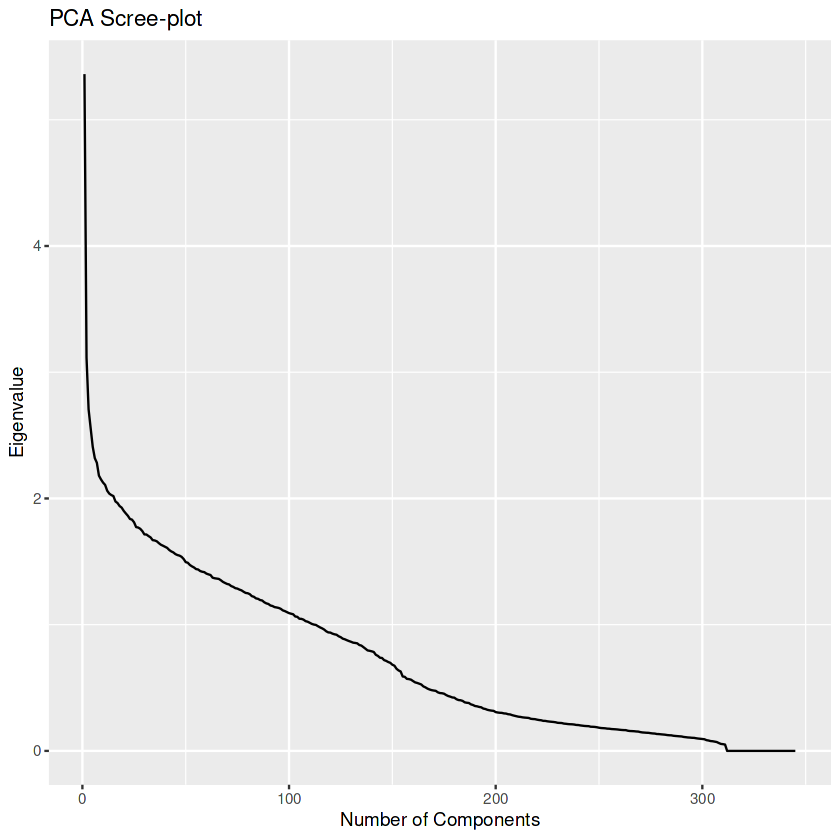

In [28]:
## Block 5
# Inspect the importance of the components, 
# and select the optimal number of components
comp_importance = pca_result$sdev %>% 
    as.data.frame() %>% 
    mutate(n_comps = row_number())

colnames(comp_importance)[1] = "eigenvalue"

comp_importance %>% head()
    
# Make scree-plot
ggplot(comp_importance, aes(x = n_comps, y = eigenvalue)) +
    geom_line(stat="identity") +
    labs(x = "Number of Components", y = "Eigenvalue", title = "PCA Scree-plot")

# Eye-balling the scree-plot, 150 components seems about optimal
best_n_comps = 150

In [29]:
## Block 6
# Create the final data frame used for doing the PCR
dat_pca = pca_result$x[, 1:best_n_comps] %>%
    as.data.frame() %>%
    mutate(y = y2) %>%
    select(y, everything())

cat("Created 'dat_pca'")
dim(dat_pca)

Created 'dat_pca'

[1] 1000  151

Now that the data frame has been prepared, the PCR analysis can be done. 5-folds cross-validation is employed to estimate test performance.

In [30]:
## Block 7
# Do a principal component regression (PRC) on the  previously extracted principal 
# component scores. In this case, a logistic regression is performed.

# Create the cross-validation controller
ctrl = trainControl(
  method = "cv", 
  number = 5,
  summaryFunction = twoClassSummary,  # Required twoClassSummary for AUC
  classProbs = TRUE  # Required for ROC calculation
  )

# Do the PCR
pcr_result = train(y ~ ., 
                    data = dat_pca, 
                    method = "glm", 
                    trControl = ctrl,
                    metric = "ROC")

cat("Succesfully performed PCR")

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Succesfully performed PCR

### 5.1.2. Partial Least Squares (PLS)

Partial least squares (PLS) is similar to principal component regression, as it performs regression on a set of principal components, which are a linear transformation of the original data. However unlike PCR, PLS is supervised, and attempts to obtain principal components in such a way that the relation to the outcome variable of interest is preserved.

Block 1 constructs the data frame used in the analysis.

In [31]:
### Block 1
## Having previously created X and y2

# plsr() requires the response variable to be numeric
y_to_binary = Vectorize(function(x) {
    if (is.na(x))
        return(NA)
    if (x == "satisfied")
        return(1)
    if (x == "dissatisfied")
        return(0)
})

y2 = y_to_binary(y2)

# Create the final data frame used for PLS
dat <- X %>%
    as("matrix") %>%
    as.data.frame() %>%
    mutate(y = y2) %>%
    select(y, everything())

cat("Created 'dat'")
dim(dat)

Created 'dat'

[1] 1000  346

With the data frame prepared, the PLS can be done. Again, data is standardized when doing the analysis. Cross-validation is employed to estimate the model's test performance.

In [32]:
## Block 2
# Perform a partial least squares (PLS) regression
pls_fit = plsr(y ~ ., data = dat, scale = TRUE , validation = "CV")

cat("Succesfully performed PLS")

# Report the result. Will show training and testing performance 
# for a range of components that were considered.
#summary(pls_fit) # Commented out because the output is too lengthy

# Report the result. Plot the mean squared error of prediction (MSEP)
# as a function of the number of components
#validationplot(pls_fit , val.type = "MSEP")

Succesfully performed PLS

The optimal number of components was chosen based on the prediction residual sum of squares (PRESS). Lower PRESS values indicate better performance. Up to 300 components, the PRESS metric was virtually a flat line on the graph, after which it increased sharply. Not wanting to be overly conservative by selecting fewer than ten components, the largest span of components at negligible cost in PRESS was chosen. Hence, 300 components was deemed optimal.

n_components,pred_sum_sq
<dbl>,<dbl>
2,149.6003
3,150.9630
1,153.7683
4,161.0406
5,171.3584
6,178.5002


Best number of components = 300



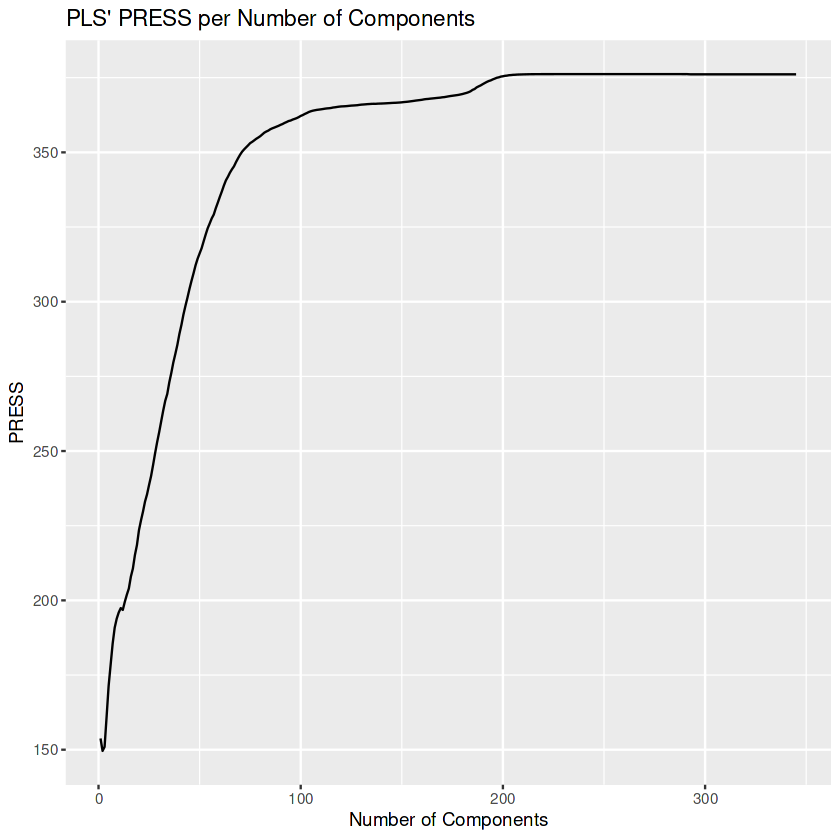

In [33]:
## Block 3
# Create a data frame which can be used to
# programmatically select the optimal number of components,
# then select the optimal number of components.
# Note. PRESS stands for 'prediction residual sum of squares'

pls_cv_result <- pls_fit$validation$PRESS %>% 
  t() %>% 
  as.data.frame()

pls_cv_result <- pls_cv_result %>%
  mutate(
    n_components = row.names(pls_cv_result),
    n_components = str_replace(n_components, " comps", ""),
    n_components = as.numeric(n_components)
  ) %>%
  select(n_components, y) %>% # Rearrange column order
  rename(pred_sum_sq = y) %>%
  as_tibble() %>% 
  arrange(pred_sum_sq)

# Report the result (it mirrors the output from the previous summary, 
# but arranged by best components)
pls_cv_result %>% head()

best_n_comp <- 300

# Report result
cat(sprintf("Best number of components = %s\n\n", best_n_comp))

# Visualize result
ggplot(pls_cv_result, aes(x = n_components, y = pred_sum_sq)) +
    geom_line() +
    labs(
        x = "Number of Components", 
        y = "PRESS", 
        title = "PLS' PRESS per Number of Components"
    )

### 5.1.3. Lasso Regression

In the next step, we fit a cross-validated Lasso Regression. The Lasso Regression prevents overfitting to the training data by surpressing large coefficients. To estimate the optimal value of the surpressor lambda, we perform cross-validated feature tuning using 'cv.glmnet'. In line with the evaluation criteria, we specify the AUC as our tuning criterion. To keep the runtime low, we use five folds for cross validation, test only 40 different lambdas, and use all four available CPU cores. We standardise our predictor variables to avoid a disproportional surpression depending on the scale of each feature.

* **family = binomial** --> binary target variable (i.e., satisfied/dissatisfied)

* **standardise = TRUE** --> x variable standardization prior to fitting the model sequence

* **alpha = 1** --> usage of lasso regression

* **parallel = TRUE** --> multiple CPU cores to speed up the cross-validation process

* **type.measure = 'auc'** --> AUC as a performance measure for CV

* **nfold = 5** --> 5 folds for CV

In [34]:
# Use four cores
doMC::registerDoMC(cores = 4) 

# Find optimal lambda using cross validation
cv_fitlasso = glmnet::cv.glmnet(train_sparse,
                                y,
                                alpha=1,
                                nlambda=40,
                                family="binomial",
                                type.measure="auc",
                                nfolds=5,
                                parallel=TRUE)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-7



Below, we visualise how the AUC of the model changes depending on lambda. A lambda of around 0.011 seems optimal resulting in an auc of 0.88.

[1] 0.00431411

[1] 0.9007183

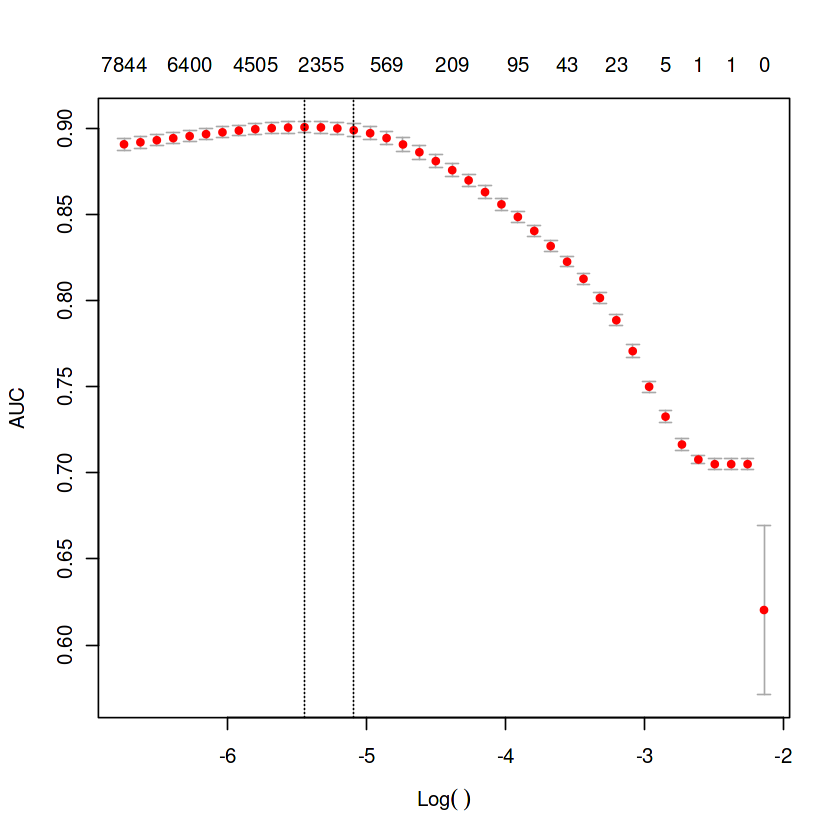

In [35]:
# Lambda with largest auc
cv_fitlasso$lambda.min
# AUC with optimal lambda
max(cv_fitlasso$cvm)

# Plot AUC against lambda
plot(cv_fitlasso)

### 5.1.4. Ridge Regression

To run a Ridge Regression, we can use our ratings data frame from the lasso regression. The function and the rationale for the different paramters is mostly the same. We force cv.glmnet to use a pure Ridge by specifying alpha=0. 

* **family = binomial** --> binary target variable

* **standardise = TRUE** --> x variable standardization prior to fitting the model sequence

* **alpha = 0** --> usage of ridge regression

* **parallel = TRUE** --> multiple CPU cores to speed up the cross-validation process

* **type.measure = 'auc'** --> AUC as a performance measure for CV

* **nfold = 5** --> 5 folds for CV

In [36]:
# Find optimal lambda using cross validation
cv_fitridge = glmnet::cv.glmnet(train_sparse,
                                y,
                                alpha=0,
                                nlambda=40,
                                family="binomial",
                                type.measure="auc",
                                nfolds=5,
                                parallel=TRUE)

Below, we visualise how the AUC of the model changes depending on lambda. A lambda of around 1.44 seems optimal resulting in an auc of 0.836.

[1] 1.88763

[1] 0.877841

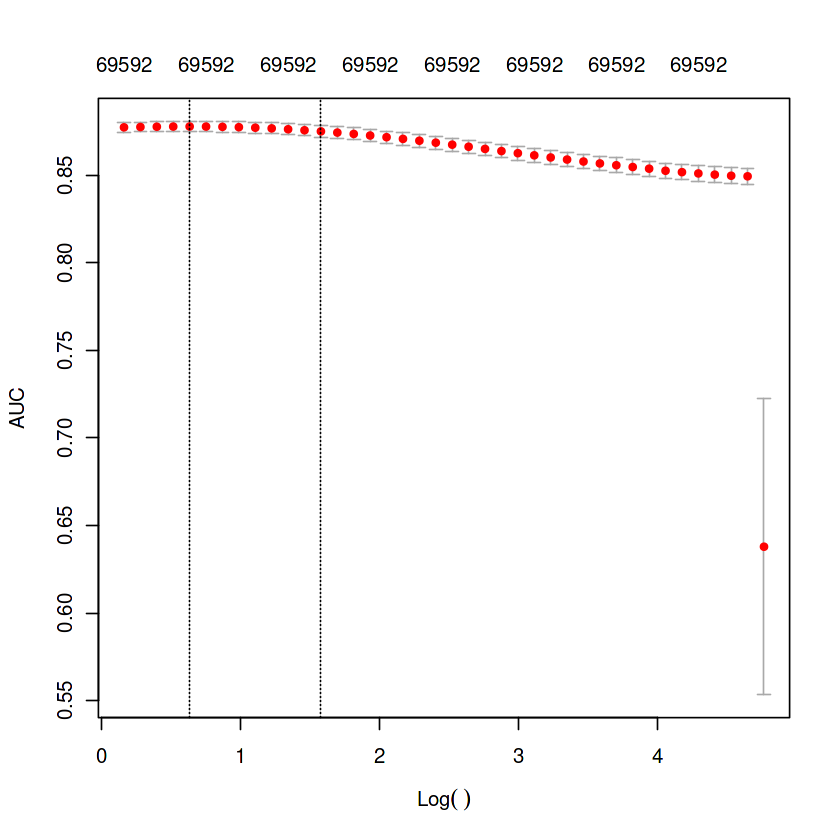

In [37]:
# Lambda with largest auc
cv_fitridge$lambda.min

# AUC with optimal lambda
max(cv_fitridge$cvm)

# Plot AUC against lambda
plot(cv_fitridge)

### 5.1.5. Smoothing

When dealing with high-dimensional text data, the use of splines can pose certain challenges. Splines are a regression technique that involves placing breakpoints (knots) to capture nonlinear relationships in data. However, when applied to text data with a large vocabulary of terms, the feature space becomes high-dimensional, which can lead to several issues.

In high-dimensional spaces, splines would require a substantial number of knots to effectively capture the nonlinearity in the data. This can result in a model that is prone to overfitting, where it fits the noise in the data rather than the underlying patterns. Moreover, the computational demands of fitting splines with numerous knots in such high-dimensional spaces can be quite substantial.

Text data is often represented as a Document-Term Matrix (DTM) or Term-Document Matrix (TDM), which are typically sparse. These matrices have many zero values because most terms do not appear in every document. Splines are not well-suited to handle the sparsity and discrete nature of such data effectively.

In contrast, techniques like Lasso and Ridge regression use regularization parameters (lambda) to select and shrink coefficients, effectively performing feature selection and reducing the dimensionality of the problem before fitting the model. Similarly, Principal Component Regression (PCR) and Partial Least Squares (PLS) also perform feature selection or dimensionality reduction before fitting the regression model.

Splines, on the other hand, do not perform such feature selection or dimensionality reduction. Instead, they attempt to fit a regression function at all data points, which can be computationally intensive and impractical in the case of sparse text data matrices.

## 5.2 Model evaluation

The following metrics are used to evaluate the performance of the models:
* Accuracy
* AUC value
* Sensitivity
* Specificity

### 5.2.1 Principal Component Regression evaluation

Evaluating the model, its performance is quite decent with an AUC above 0.8.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



PCR's AUC: 0.914



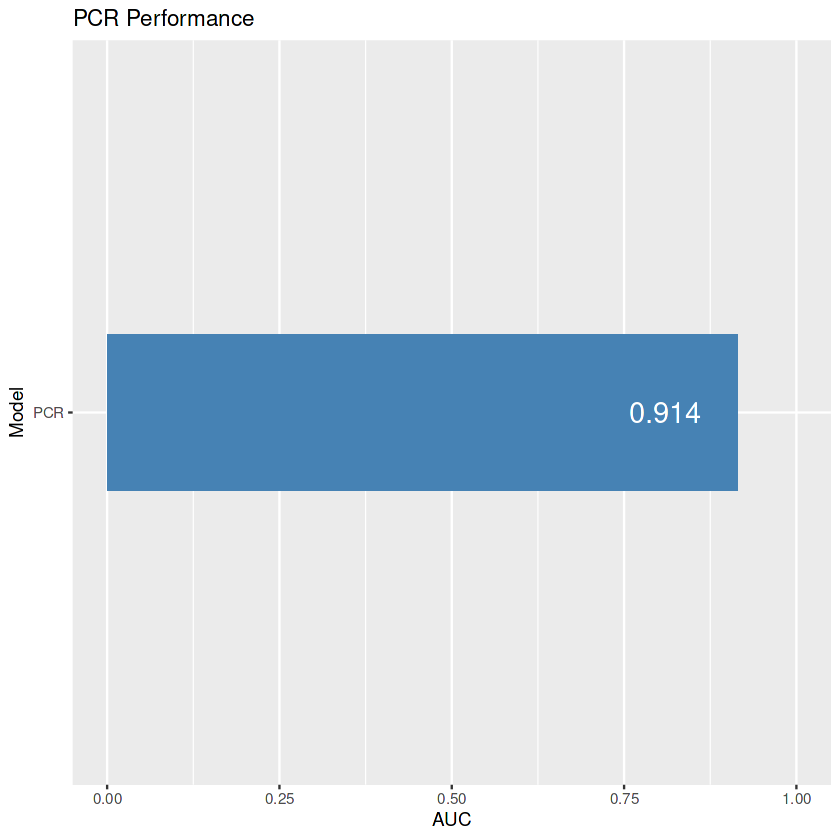

In [38]:
# Model evaluation

best_model = pcr_result$finalModel
predictions = predict(best_model, newdata = dat_pca, type = "response")
pcr_roc = pROC::roc(response = y2, predictor = predictions)
pcr_auc = round(pROC::auc(pcr_roc), 3)

# Report the performance
cat(sprintf("PCR's AUC: %s\n\n", pcr_auc))

# Visualize the performance
ggplot(tibble(x = factor("PCR"), y = pcr_auc), aes(x = x, y = y, label = y)) +
    geom_col(fill = "steelblue", width = .25) +
    geom_text(hjust = 1.5, size = 6, color = "white") +
    ylim(0, 1) +
    labs(x = "Model", y = "AUC", title = "PCR Performance") +
    coord_flip()

### 5.2.2 Least Partial Squares evaluation

Assessing the model's performance, PLS did worse than PCR in terms of AUC.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



PLS' AUC with 300 component(s) = 0.801062829671412

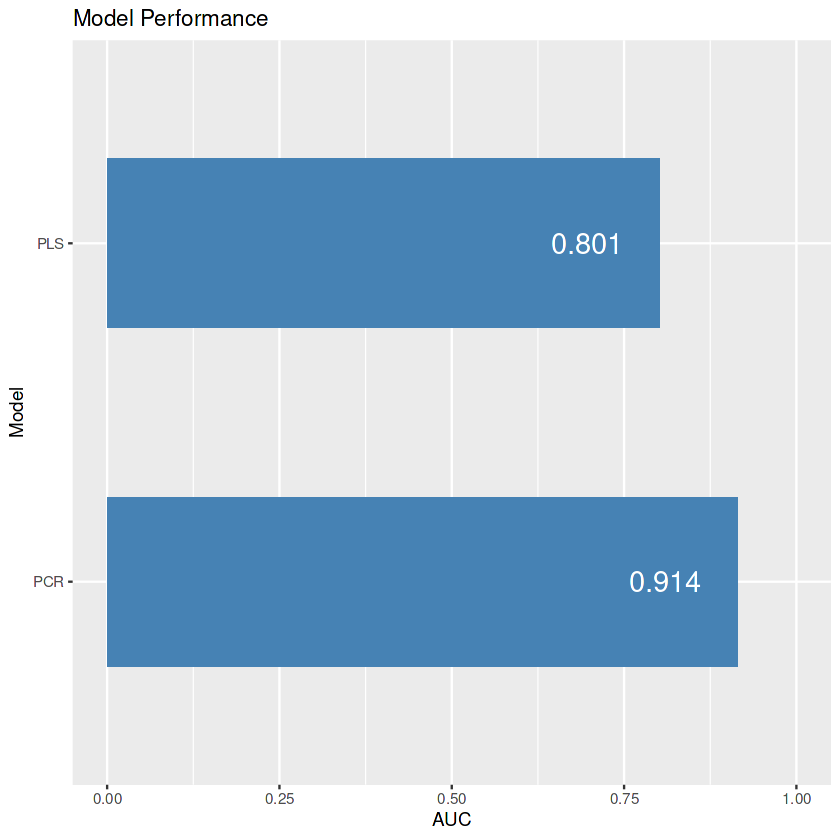

In [39]:
## BLOCK 4
# Assess model performance via AUC
pls_predictions = predict(pls_fit, dat, ncomp = best_n_comp)
# 1 codes for "satisfied", 0 for "dissatisfied"
pls_predictions = ifelse(pls_predictions > .5, 1, 0) 


pls_roc = pROC::roc(y2, pls_predictions)
pls_auc = pROC::auc(pls_roc)

# Report the performance
cat(sprintf("PLS' AUC with %s component(s) = %s", best_n_comp, pls_auc))

# Visualize the performance
aucs = c(pls_auc, pcr_auc) %>% round(3)
model_names = factor(c("PLS", "PCR"))
                      
ggplot(tibble(x = model_names, y = aucs), 
        aes(x = x, y = y, label = y)
    ) +
    geom_col(fill = "steelblue", width = .5) +
    geom_text(hjust = 1.5, size = 6, color = "white") +
    ylim(0, 1) +
    labs(x = "Model", y = "AUC", title = "Model Performance") +
    coord_flip()

### 5.2.3 Lasso evaluation

To evaluate the performance of our Lasso model, we calculate the accuracy, AUC, sensitivity, and specificity of the model on our training data.

In [40]:
# Performance of the CV lasso model on the training set
predict_lasso = predict(cv_fitlasso, train_sparse, s = 'lambda.min', type = 'class') %>% 
    as.factor()

# Confusion Matrix
Lasso_CM = caret::confusionMatrix(predict_lasso, y)
Lasso_CM

# Performance evaluations
Accuracy_fit_lasso_cv  = mean(predict_lasso == y)
AUC_fit_lasso_cv  = max(cv_fitlasso$cvm)
Sen_fit_lasso_cv = Lasso_CM$byClass[["Sensitivity"]]
Spec_fit_lasso_cv = Lasso_CM$byClass[["Specificity"]]

# Print performance criteria
cat(crayon::bold("Lasso Performances"), "\n", 
    "Accuracy:   ", Accuracy_fit_lasso_cv, "\n", 
    "     AUC:   ", AUC_fit_lasso_cv, "\n",
    "Sensitivity:", Sen_fit_lasso_cv, "\n", 
    "Specificity:", Spec_fit_lasso_cv, "\n",
    "Best Lambda:", cv_fitlasso$lambda.min, "\n\n",
    crayon::bold("Ridge Performances"), "\n")

Confusion Matrix and Statistics

              Reference
Prediction     dissatisfied satisfied
  dissatisfied         3027       360
  satisfied            1661     14952
                                          
               Accuracy : 0.899           
                 95% CI : (0.8947, 0.9031)
    No Information Rate : 0.7656          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6885          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.6457          
            Specificity : 0.9765          
         Pos Pred Value : 0.8937          
         Neg Pred Value : 0.9000          
             Prevalence : 0.2344          
         Detection Rate : 0.1514          
   Detection Prevalence : 0.1694          
      Balanced Accuracy : 0.8111          
                                          
       'Posi

Lasso Performances 
 Accuracy:    0.89895 
      AUC:    0.9007183 
 Sensitivity: 0.6456911 
 Specificity: 0.976489 
 Best Lambda: 0.00431411 

 Ridge Performances 


### 5.2.4 Ridge evaluation

To evaluate the performance of our Ridge model, we calculate the accuracy, AUC, sensitivity, and specificity of the model on our training data.

In [41]:
# Performance of the cross-validated lasso model on the training set
predict_ridge = predict(cv_fitridge, train_sparse, s = 'lambda.min', type = 'class') %>% 
    as.factor()

# Confusion Matrix
Ridge_CM = caret::confusionMatrix(predict_ridge, y)
Ridge_CM

# Performance evaluations that can be plotted for visual inspection
Accuracy_fit_ridge_cv  = mean(predict_ridge == y)
AUC_fit_ridge_cv  = max(cv_fitridge$cvm)
Sen_fit_ridge_cv = Ridge_CM$byClass[["Sensitivity"]]
Spec_fit_ridge_cv = Ridge_CM$byClass[["Specificity"]]

# Print performance criteria
cat(crayon::bold("Lasso Performances"), "\n",
    crayon::bold("Ridge Performances"), "\n", 
    "Accuracy:   ", Accuracy_fit_ridge_cv, "\n", 
    "     AUC:   ", AUC_fit_ridge_cv, "\n",
    "Sensitivity:", Sen_fit_ridge_cv, "\n", 
    "Specificity:", Spec_fit_ridge_cv, "\n",
    "Best Lambda:", cv_fitridge$lambda.min, "\n")

Confusion Matrix and Statistics

              Reference
Prediction     dissatisfied satisfied
  dissatisfied         2800         7
  satisfied            1888     15305
                                          
               Accuracy : 0.9052          
                 95% CI : (0.9011, 0.9093)
    No Information Rate : 0.7656          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6933          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5973          
            Specificity : 0.9995          
         Pos Pred Value : 0.9975          
         Neg Pred Value : 0.8902          
             Prevalence : 0.2344          
         Detection Rate : 0.1400          
   Detection Prevalence : 0.1404          
      Balanced Accuracy : 0.7984          
                                          
       'Posi

Lasso Performances 
 Ridge Performances 
 Accuracy:    0.90525 
      AUC:    0.877841 
 Sensitivity: 0.5972696 
 Specificity: 0.9995428 
 Best Lambda: 1.88763 


### 5.2.5 Model selection

Given that the AUC will be the evaluation criterion for our predictions, we used the estimated AUC to select our model.

model,AUC
<chr>,<chr>
PCR,0.914
PLS,0.801062829671412
Lasso,0.900718270760191
Ridge,0.877840976502612


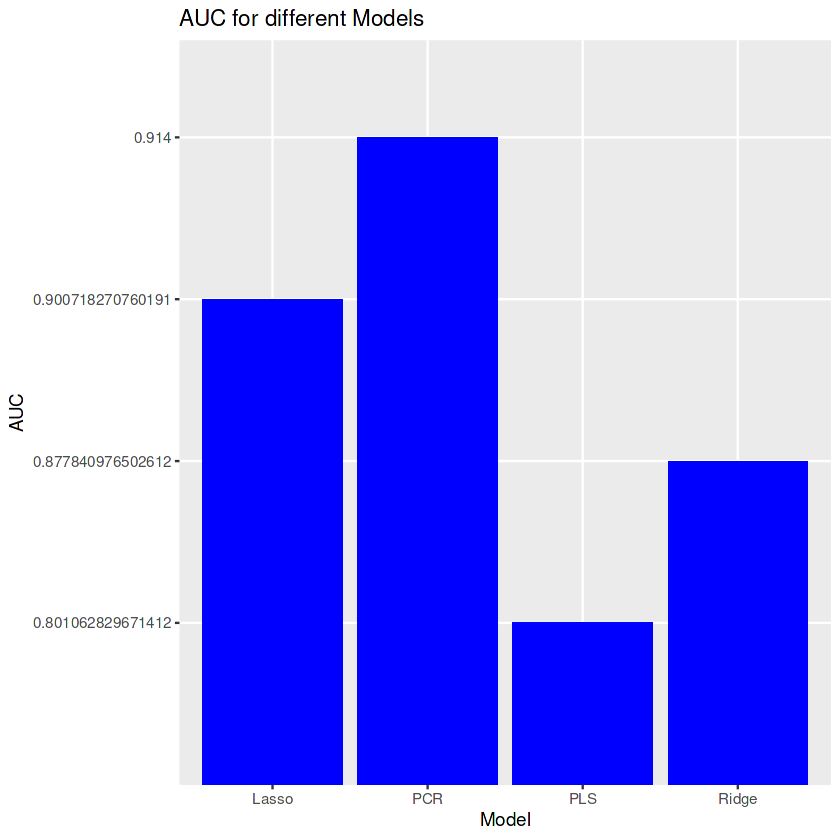

In [42]:
model_perf  = cbind(c("PCR", "PLS", "Lasso", "Ridge"), c(pcr_auc, pls_auc, AUC_fit_lasso_cv, AUC_fit_ridge_cv)) %>% as.data.frame()
colnames(model_perf) <- c("model", "AUC")

model_perf

# Create a bar plot
ggplot(model_perf, aes(x = model, y = AUC)) +
  geom_bar(stat = "identity", fill = "blue") +
  labs(x = "Model", y = "AUC", title = "AUC for different Models")

PCR had the largest AUC. However, the model was based on a relatively small subset of the total observations due to the long computing times. This means that the PCR may be more biased than other models. Therefore, we decided to make our predictions based on the Lasso model, which used more observations while still producing a good AUC.

In [43]:
winner_model = cv_fitlasso


# 6. Submitting your predictions

We use the sample predictions to make sure that our predictions match the expected format. For this purpose, we first load the sample predictions from the inpur data.

In [44]:
# Find file path of sample predictions
sample_filepath = dir("..", pattern="sample.csv", recursive=TRUE, full.names = TRUE)

# Load sample predictions into data frame
sample_submission = read_csv(sample_filepath, col_types = cols(col_character(), col_double()))

head(sample_submission)

Id,Prediction
<chr>,<dbl>
3,0.5715225
5,0.9033234
8,0.7865691
14,0.6911136
20,0.7673936
22,0.1852140


Now, we can make our own predictions based on our best-performing model and the features of the test reviews, which were already part of our initial design matrix. In step 5, we identified the rows of our design matrix that contained the test reviews, so we can use these indexes again now to select the right rows. Subsequently, we left-join our predictions with the sample predictions to make sure that there is one predictions for each review in the test data.

In [45]:
# Extract test rows from design matrix
test_sparse = features_sparse[na_ind,]

# Save predictions in data frame
predictions = predict(winner_model, newx=test_sparse, type="response") %>% as.data.frame()
colnames(predictions) = "Prediction" # Change column name for merging
predictions$Id = rownames(predictions) # Save IDs in column

# Join predictions with IDs from sample submission
id_test = sample_submission %>% select(Id)
predictions = left_join(id_test, predictions, by="Id")

head(predictions)
tail(predictions)
dim(predictions)

Id,Prediction
<chr>,<dbl>
3,0.8927449
5,0.9570996
8,0.9368798
14,0.7284520
20,0.6686638
22,0.2581856


Id,Prediction
<chr>,<dbl>
183476,0.8832559
183478,0.8037694
183507,0.7629844
183518,0.9584655
183525,0.9428211
183528,0.7377078


[1] 30000     2

We save our predictions in a CSV file.

In [46]:
# Write your predictions data frame to file
write_csv(predictions, file="predictions.csv")

# 7. References

* dan_vdmeer, Dave Leitritz, Joost van Kordelaar, Raoul. (2023). BDA 2023 Customer sentiment from reviews. Kaggle. https://kaggle.com/competitions/customer-sentiment-from-reviews-bda-2023

* dan_vdmeer, Dave Leitritz, Raoul. (2023). BDA 2023 Profiling Personality. Kaggle. https://kaggle.com/competitions/bda-2023-profiling-personality

# 8. Contributions

* Julius Thomas: most of pre-processing and feature creation, Ridge and Lasso fitting, features into a dataframe

* Sam Semegne: Descriptions, Partial Least Squares, Principal Components Regression, some features

* Bence Marosi: Most of the descriptions, merging, model evaluations, word cloud, data pre-processing partly, document shaping, TD-IDF integration